# Graph Algorithms

## 1. Stock Market

In this part of the project, we study data from stock market. The data is available on this
Dropbox Link. The goal of this part is to study correlation structures among 
uctuation
patterns of stock prices using tools from graph theory. The intuition is that investors will have
similar strategies of investment for stocks that are effected by the same economic factors. For
example, the stocks belonging the transportation sector may have different absolute prices, but
if for example fuel prices change or are expected to change signicantly in the near future, then
you would expect the investors to buy or sell all stocks similarly and maximize their returns.
Towards that goal, we construct different graphs based on similarities among the time series of
returns on different stocks at different time scales (day vs a week). Then, we study properties
of such graphs. The data is obtained from Yahoo Finance website for 3 years. You're provided
with a number of csv tables, each containing several elds: Date, Open, High, Low, Close,
Volume, and Adj Close price. The les are named according to Ticker Symbol of each stock.
You may nd the market sector for each company in Name sector.csv.

1. Return correlation
In this part of the project, we will compute the correlation among log-normalized stock-return
time series data. Before giving the expression for correlation, we introduce the following nota-
tion:

    pi(t) is the closing price of stock i at the tth day
    
    qi(t) is the return of stock i over a period of [t - 1, t]
    
    qi(t) = (pi(t) - pi(t - 1))/pi(t - 1)
    
    ri(t) is the log-normalized return stock i over a period of [t - 1, t]
    
    ri(t) = log(1 + qi(t)
    
    Then with the above notation, we dene the correlation between the log-normalized stock-return time series data of stocks i and j as
    pij = (⟨ri(t)rj(t)⟩ - ⟨ri(t)⟩⟨rj(t)⟩)/sqrt(⟨ri(t)2⟩ - ⟨ri(t)⟩2)(⟨rj(t)2⟩ - ⟨rj(t)⟩2)
    where ⟨⟩ is a temporal average on the investigated time regime (for our data set it is over 3 years).

### Question 1

What are upper and lower bounds on pij? Provide a justification for using log-normalized return (ri(t)) instead of regular return (qi(t)).

In [1]:
import csv
import math

nameSec = csv.reader(open('D:/documents/UCLA_Graduate/Sem3/EE232E/project4/finance_data/Name_sector.csv'))

nameSecArr = {}
namePriceArr = {}
nameReturnArr = {}
nameLogReturnArr = {}
correlationArr = {}

for row in nameSec:
    if row[0] == 'Symbol':
        continue
    else:
        nameSecArr[row[0]] = row[1]

for name in nameSecArr:
    file = 'D:/documents/UCLA_Graduate/Sem3/EE232E/project4/finance_data/data/' + name + '.csv'
    dataset = csv.reader(open(file))
    for row in dataset:
        if row[0] == 'Date':
            continue
        else:
            if name in namePriceArr:
                namePriceArr[name].append((row[0],eval(row[4])))
            else:
                namePriceArr[name] = [(row[0],eval(row[4]))]
#print (len(namePriceArr['A'])) #765

for name in namePriceArr:
    r_list = []
    for i in range(1,len(namePriceArr[name])):
        price_i = namePriceArr[name][i][1]
        price_iminors = namePriceArr[name][i-1][1]
        returnStock = (price_i - price_iminors)/price_i
        r_list.append(returnStock)
    nameReturnArr[name] = r_list
#print(len(nameReturnArr)) #505
#print(len(nameReturnArr['A'])) #764

for name in nameReturnArr:
    for i in nameReturnArr[name]:
        r = math.log(abs(1 + i))
        if name in nameLogReturnArr:
            nameLogReturnArr[name].append(r)
        else:
            nameLogReturnArr[name] = [r]

def correlationCal(return_i, return_j):
    if len(return_i) > len(return_j):
        return_i = return_i[0:len(return_j)]
    elif len(return_i) < len(return_j):
        return_j = return_j[0:len(return_i)]
    #lengths of returns are the same
    arrLen = len(return_i)
    
    product = 0
    sum_i = 0
    sum_j = 0
    sqrReturn_i = 0
    sqrReturn_j = 0
    for t in range(0,arrLen):
        product = product + return_i[t]*return_j[t]
        sum_i = sum_i + return_i[t]
        sum_j = sum_j + return_j[t]
        sqrReturn_i = sqrReturn_i + return_i[t]*return_i[t]
        sqrReturn_j = sqrReturn_j + return_j[t]*return_j[t]
    avgProduct = product/arrLen
    avgSum_i = sum_i/arrLen
    avgSum_j = sum_j/arrLen
    avgSqrReturn_i = sqrReturn_i/arrLen
    avgSqrReturn_j = sqrReturn_j/arrLen

    correlation = (avgProduct - avgSum_i*avgSum_j)/math.sqrt((avgSqrReturn_i-avgSum_i*avgSum_i)*(avgSqrReturn_j-avgSum_j*avgSum_j))
    return correlation
                
for name_i in nameLogReturnArr:
    for name_j in nameLogReturnArr:
        if name_i == name_j:
            continue
        elif (name_i,name_j) in correlationArr:
             continue
        elif (name_j,name_i) in correlationArr:
             continue
        else:
            correlationArr[(name_j,name_i)] = correlationCal(nameLogReturnArr[name_i],nameLogReturnArr[name_j])
            #print(correlationArr[(name_j,name_i)])
        

In [2]:
minValue = 1
maxValue = -1
for test in correlationArr:    
    #print(correlationArr[test])
    x = correlationArr[test]
    if x > maxValue:
        maxValue = x
    elif x < minValue:
        minValue = x
print(minValue)
print(maxValue)        

-0.9553628243170165
0.9990862047478959


## 2. Constructing correlation graphs

In this part,we construct a correlation graph using the correlation coefficient computed in the
previous section. The correlation graph has the stocks as the nodes and the edge weights are
given by the following expression
wij = sqrt(2(1-pi))

Compute the edge weights using the above expression and construct the correlation graph.

### Question 2

Plot a histogram showing the un-normalized distribution of edge weights.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = nx.Graph()
for name in nameLogReturnArr:
    G.add_node(name)

edgeWeight = {}
for test in correlationArr:
    x = correlationArr[test]
    w = math.sqrt(2*(1-x))
    if test in edgeWeight:
        edgeWeight[test].append(w)
    else:
        edgeWeight[test] = [w]
    G.add_edge(test[0], test[1], weight = w)

C:\Users\yifan\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


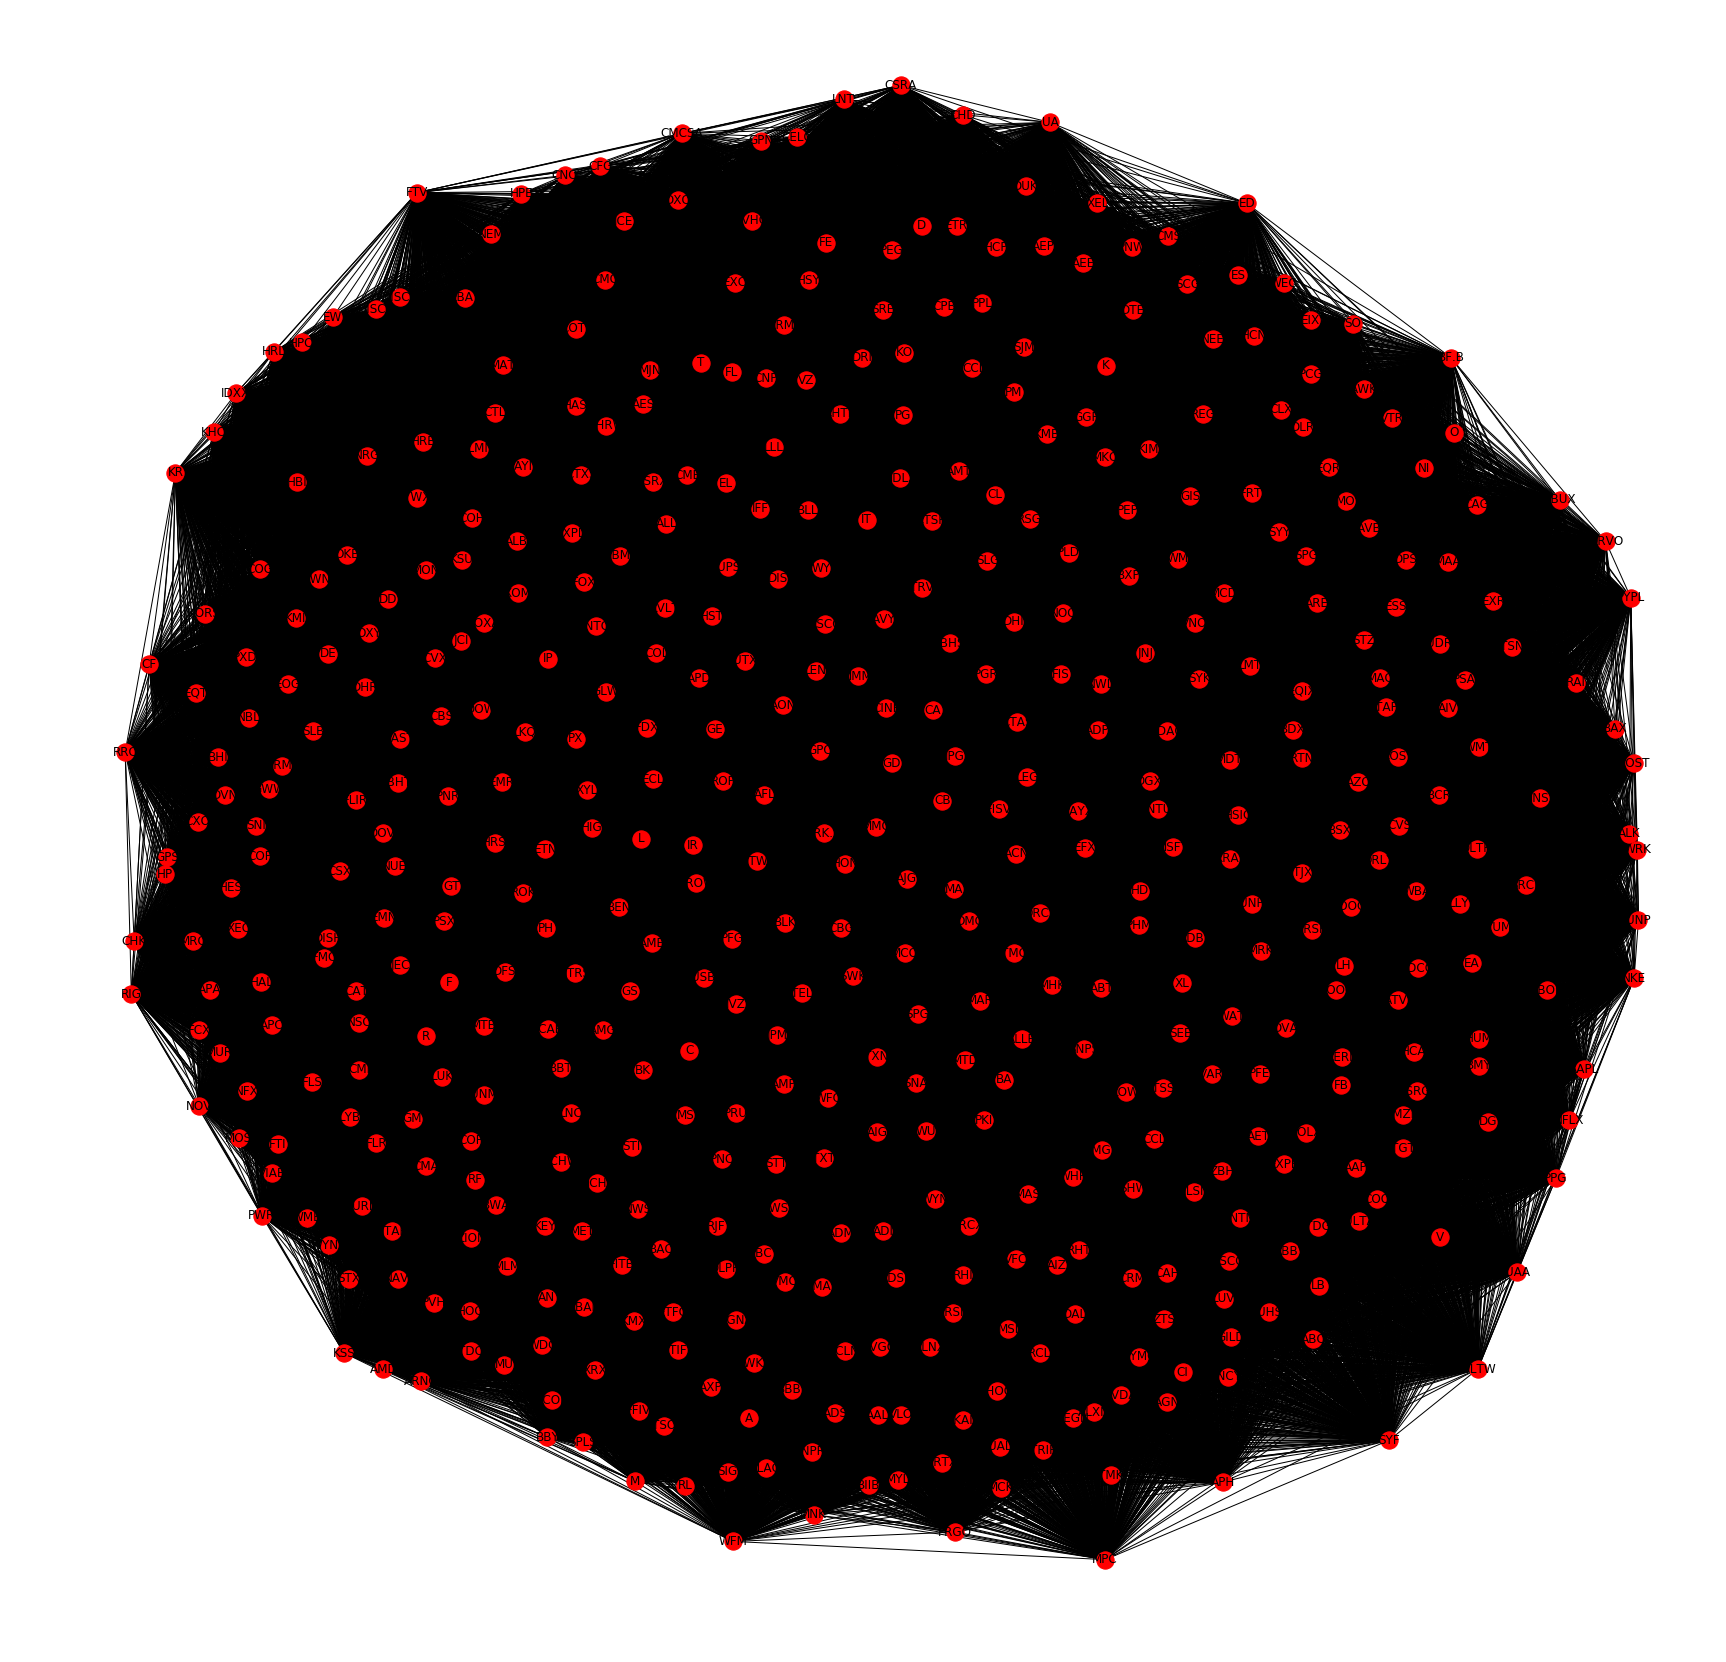

In [4]:
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(30,30))
plt.axis('off')
nx.draw_networkx(G,pos)
plt.show()

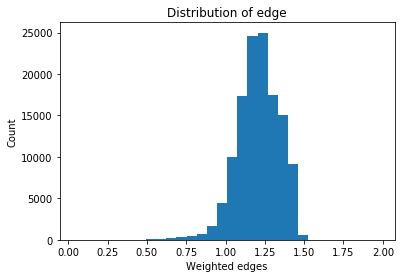

In [5]:
hist_g = []

for test in edgeWeight: 
    x = sum(edgeWeight[test])/len(edgeWeight[test])
    hist_g.append(x)
    
plt.hist(hist_g, density=False, bins=30)
plt.xlabel('Weighted edges')
plt.ylabel('Count')
plt.title('Distribution of edge')
plt.show()    

## 3. Minimum spanning tree (MST)

In this part of the project, we will extract the MST of the correlation graph and interpret it.

### Question 3

Extract the MST of the correlation graph. Each stock can be categorized into
a sector, which can be found in Name sector.csv le. Plot the MST and color-code the nodes
based on sectors. Do you see any pattern in the MST? The structures that you nd in MST are
called Vine clusters. Provide a detailed explanation about the pattern you observe.

In [7]:
import random
T = nx.minimum_spanning_tree(G)
#print(sorted(T.edges(data=True))) [('A', 'LH', {'weight': 1.0117622221417724}),('AAL', 'DAL',...
categoryArr = []
for name in nameLogReturnArr:
    T.nodes[name]['sector'] = nameSecArr[name]       
    #print(T.nodes[name]['sector'])
    if nameSecArr[name] in categoryArr:
        continue
    else:
        categoryArr.append(nameSecArr[name])
#print(categoryArr) ['Health Care', 'Industrials', 'Consumer Discretionary', 'Information Technology', 'Consumer Staples', 'Utilities', 'Financials', 'Real Estate', 'Materials', 'Energy', 'Telecommunication Services']
#print(len(categoryArr))

In [8]:
import random

number_of_colors = len(categoryArr)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(number_of_colors)]

color = []
for node in T.nodes:
    for i in range(0, number_of_colors):
        if T.nodes[node]['sector'] == categoryArr[i]:
            color.append(colors[i])

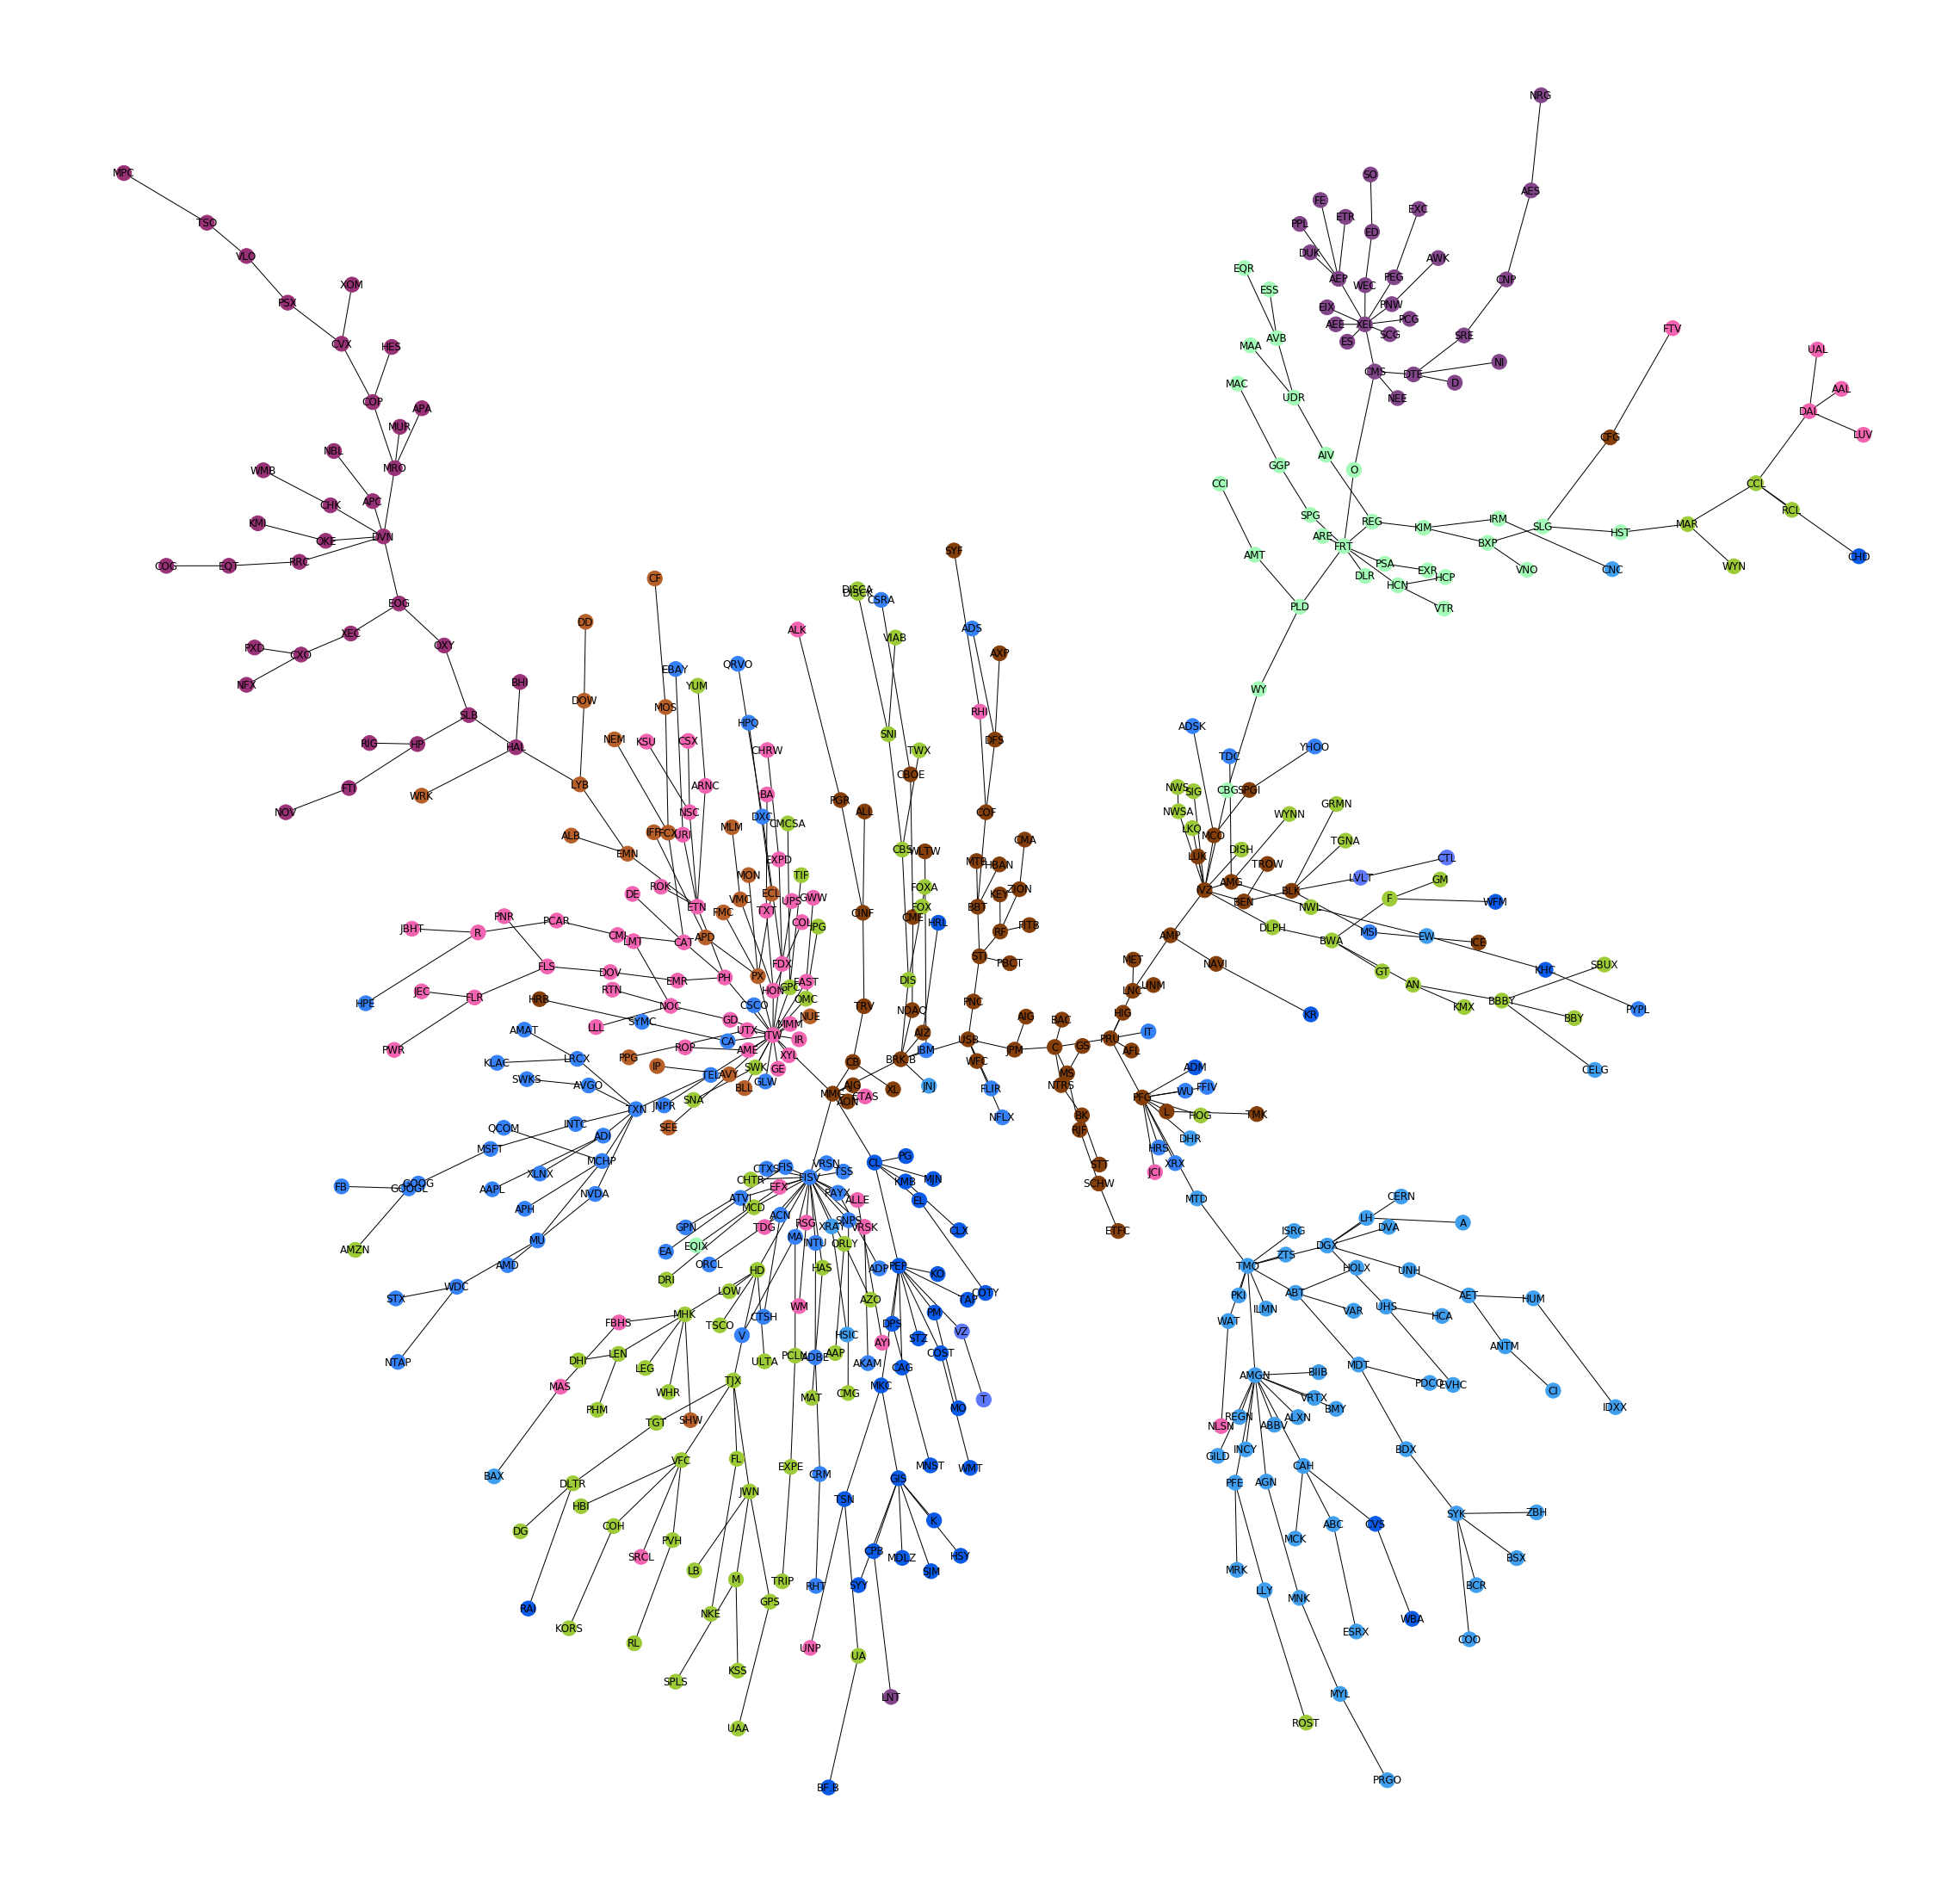

In [9]:
pos2 = nx.kamada_kawai_layout(T)
plt.figure(figsize=(40,40))
plt.axis('off')
nx.draw_networkx(T,pos2, node_color = color)
plt.show()

## 4. Sector clustering in MST's

In this part, we want to predict the market sector of an unknown stock. We will explore two
methods for performing the task. In order to evaluate the performance of the methods we
define the following metric
a = (1/|V|)*sum(P(vi in Si)) via vi in V
where Si is the sector of node i. Define
P(vi in Si) = |Qi|/|Ni|
where Qi is the set of neighbors of node i that belong to the same sector as node i and Ni is
the set of neighbors of node i. Compare  with the case where
P(vi in Si) = |Si|/|V|

### Qustion4

Report the value of a for the above two cases and provide an interpretation for
the difference.

In [17]:
V_length = len(T.nodes)
alpha = 0
for node1 in T.nodes:
    Ni = 0
    Qi = 0
    for node2 in T.neighbors(node1):
        Ni = Ni + 1
        if T.nodes[node1]['sector'] == T.nodes[node2]['sector']:
            Qi = Qi + 1
    alpha = alpha + Qi / Ni
print('first method alpha is: ', alpha/V_length)

first method alpha is:  0.7887932644196097


In [28]:
sum_alpha = 0
for i in range(0, len(categoryArr)):
    Si =0
    alpha = 0
    for node1 in T.nodes:
        if T.nodes[node1]['sector'] == categoryArr[i]:
            Si = Si + 1
        alpha = alpha + Si/V_length
    print('second method alpha for sector',categoryArr[i] ,'is: ', alpha/V_length)    
    sum_alpha = sum_alpha + alpha/V_length
print('second method alpha is: ', sum_alpha/len(categoryArr)) 
    

second method alpha for sector Health Care is:  0.06660131359670587
second method alpha for sector Industrials is:  0.06313498676600318
second method alpha for sector Consumer Discretionary is:  0.07705911185177904
second method alpha for sector Information Technology is:  0.07098519752965389
second method alpha for sector Consumer Staples is:  0.03496912067444357
second method alpha for sector Utilities is:  0.029314773061464496
second method alpha for sector Financials is:  0.06789922556612067
second method alpha for sector Real Estate is:  0.0318321733163414
second method alpha for sector Materials is:  0.025511224389765576
second method alpha for sector Energy is:  0.030906773845701306
second method alpha for sector Telecommunication Services is:  0.002776198411920402
second method alpha is:  0.045544554455445405


## 5. Correlation graphs for weekly data

In the previous parts, we constructed the correlation graph based on daily data. In this part of
the project, we will construct a correlation graph based on weekly data. To create the graph,
sample the stock data weekly on Mondays and then calculate ij using the sampled data. If
there is a holiday on a Monday, we ignore that week. Create the correlation graph based on
weekly data.

### Question 5

Extract the MST from the correlation graph based on weekly data. Compare the
pattern of this MST with the pattern of the MST found in Question 3.

In [30]:
import csv
import math

nameSec = csv.reader(open('D:/documents/UCLA_Graduate/Sem3/EE232E/project4/finance_data/Name_sector.csv'))

nameSecArr = {}
namePriceArr = {}
nameReturnArr = {}
nameLogReturnArr = {}
correlationArr = {}

for row in nameSec:
    if row[0] == 'Symbol':
        continue
    else:
        nameSecArr[row[0]] = row[1]

for name in nameSecArr:
    file = 'D:/documents/UCLA_Graduate/Sem3/EE232E/project4/finance_data/data/' + name + '.csv'
    dataset = csv.reader(open(file))
    for row in dataset:
        if row[0] == 'Date':
            continue
        else:
            if name in namePriceArr:
                namePriceArr[name].append((row[0],eval(row[4])))
            else:
                namePriceArr[name] = [(row[0],eval(row[4]))]
#print (len(namePriceArr['A'])) #765

import time
import datetime
nameSmpPriceArr = {}
for name in namePriceArr:
    if namePriceArr[name][0][0] == '2014-05-01':
        for i in range(0,len(namePriceArr[name])):
            strdate = namePriceArr[name][i][0]
            weekday = datetime.datetime.strptime(strdate,'%Y-%m-%d')
            weekdayname = weekday.strftime("%A")
            if weekdayname == 'Monday':
                if name in nameSmpPriceArr:
                    nameSmpPriceArr[name].append(namePriceArr[name][i])
                else:
                    nameSmpPriceArr[name] = [namePriceArr[name][i]]


C:\Users\yifan\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


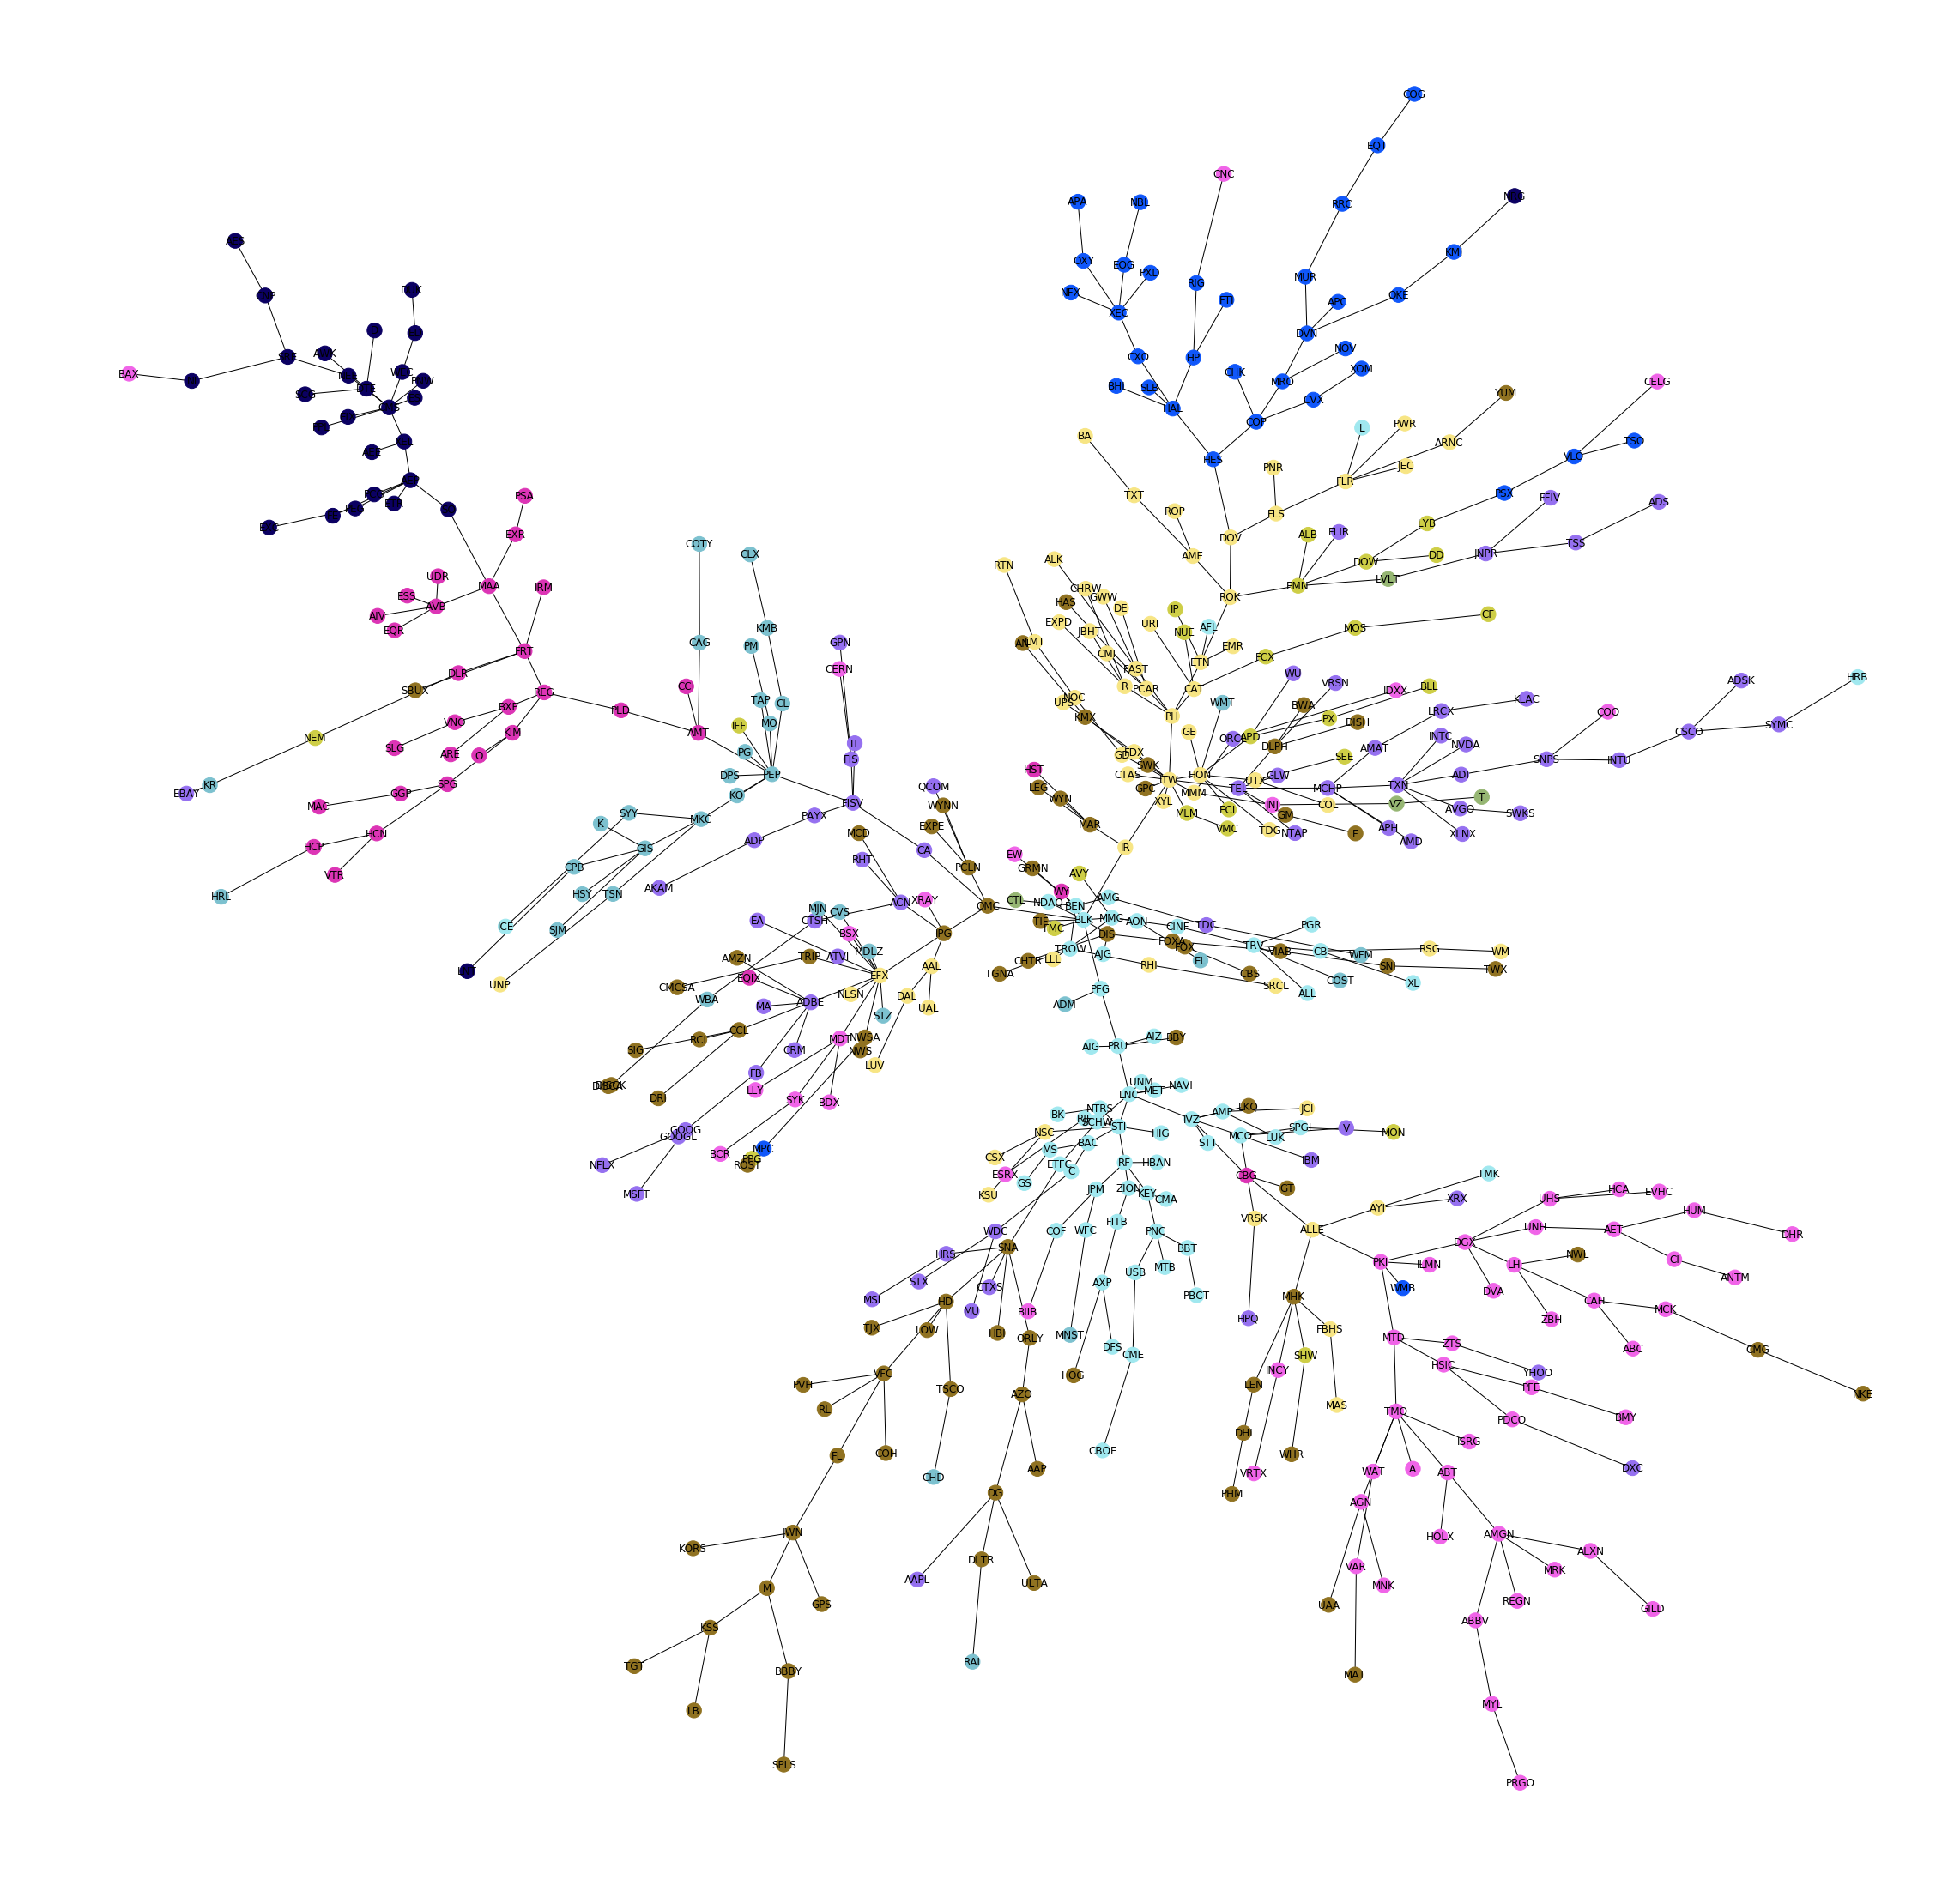

In [31]:
for name in nameSmpPriceArr:
    r_list = []
    for i in range(1,len(nameSmpPriceArr[name])):
        price_i = nameSmpPriceArr[name][i][1]
        price_iminors = nameSmpPriceArr[name][i-1][1]
        returnStock = (price_i - price_iminors)/price_i
        r_list.append(returnStock)
    nameReturnArr[name] = r_list
#print(len(nameReturnArr)) #505
#print(len(nameReturnArr['A'])) #764

for name in nameReturnArr:
    for i in nameReturnArr[name]:
        r = math.log(abs(1 + i))
        if name in nameLogReturnArr:
            nameLogReturnArr[name].append(r)
        else:
            nameLogReturnArr[name] = [r]

def correlationCal(return_i, return_j):
    if len(return_i) > len(return_j):
        return_i = return_i[0:len(return_j)]
    elif len(return_i) < len(return_j):
        return_j = return_j[0:len(return_i)]
    #lengths of returns are the same
    arrLen = len(return_i)
    
    product = 0
    sum_i = 0
    sum_j = 0
    sqrReturn_i = 0
    sqrReturn_j = 0
    for t in range(0,arrLen):
        product = product + return_i[t]*return_j[t]
        sum_i = sum_i + return_i[t]
        sum_j = sum_j + return_j[t]
        sqrReturn_i = sqrReturn_i + return_i[t]*return_i[t]
        sqrReturn_j = sqrReturn_j + return_j[t]*return_j[t]
    avgProduct = product/arrLen
    avgSum_i = sum_i/arrLen
    avgSum_j = sum_j/arrLen
    avgSqrReturn_i = sqrReturn_i/arrLen
    avgSqrReturn_j = sqrReturn_j/arrLen

    correlation = (avgProduct - avgSum_i*avgSum_j)/math.sqrt((avgSqrReturn_i-avgSum_i*avgSum_i)*(avgSqrReturn_j-avgSum_j*avgSum_j))
    return correlation
                
for name_i in nameLogReturnArr:
    for name_j in nameLogReturnArr:
        if name_i == name_j:
            continue
        elif (name_i,name_j) in correlationArr:
             continue
        elif (name_j,name_i) in correlationArr:
             continue
        else:
            correlationArr[(name_j,name_i)] = correlationCal(nameLogReturnArr[name_i],nameLogReturnArr[name_j])
            #print(correlationArr[(name_j,name_i)])
            
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

G = nx.Graph()
for name in nameLogReturnArr:
    G.add_node(name)

edgeWeight = {}
for test in correlationArr:
    x = correlationArr[test]
    w = math.sqrt(2*(1-x))
    if test in edgeWeight:
        edgeWeight[test].append(w)
    else:
        edgeWeight[test] = [w]
    G.add_edge(test[0], test[1], weight = w)     

T = nx.minimum_spanning_tree(G)
categoryArr = []
for name in nameLogReturnArr:
    T.nodes[name]['sector'] = nameSecArr[name]       
    #print(T.nodes[name]['sector'])
    if nameSecArr[name] in categoryArr:
        continue
    else:
        categoryArr.append(nameSecArr[name])
        
number_of_colors = len(categoryArr)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(number_of_colors)]

color = []
for node in T.nodes:
    for i in range(0, number_of_colors):
        if T.nodes[node]['sector'] == categoryArr[i]:
            color.append(colors[i])
            
pos2 = nx.kamada_kawai_layout(T)
plt.figure(figsize=(40,40))
plt.axis('off')
nx.draw_networkx(T,pos2, node_color = color)
plt.show()